In [1]:
### THIS CODE IS SLOW BECUASE OF THE IMAZE SIZE OF 800 X 800 MIGHT MAKE A COPY AND CREATED A 
### PART WHERE THE IMAGE IS DOWNSIZED 

import sys
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QLabel, QLineEdit, QPushButton
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
import json
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.measure import label, regionprops
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\refad\anaconda3\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


SystemExit: 0

C:\Users\refad\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


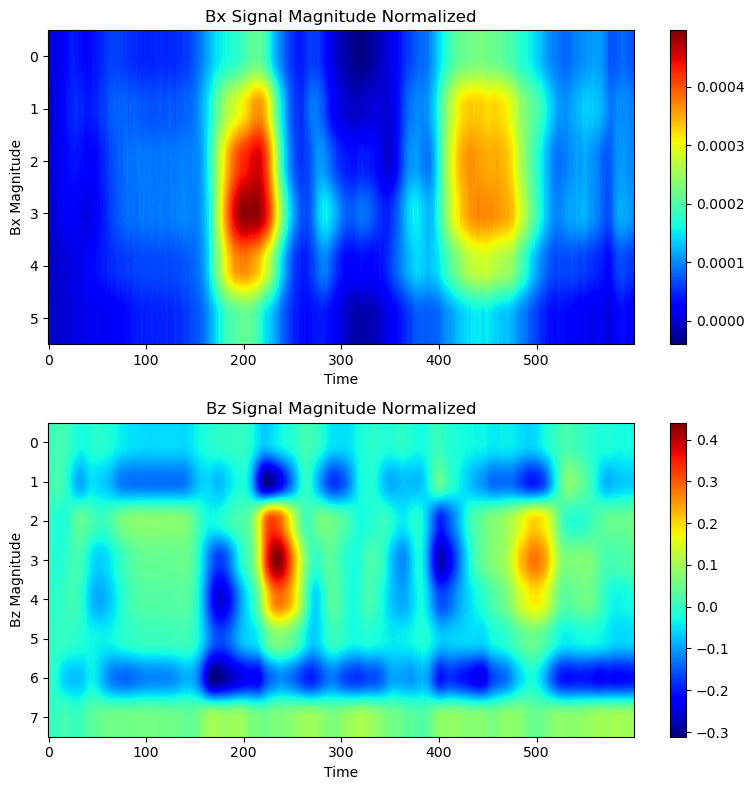

In [2]:
class CustomGUI(QMainWindow):
    def __init__(self):

        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

        super().__init__()
        self.setWindowTitle("Custom GUI with ML Integration")
        self.setGeometry(100, 100, 1000, 700)
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)
        main_layout = QVBoxLayout()

        # Range input
        panel_layout = QHBoxLayout()
        self.lower_range_label = QLabel("Enter lower range:")
        self.lower_range_input = QLineEdit(self)
        self.higher_range_label = QLabel("Enter higher range:")
        self.higher_range_input = QLineEdit(self)
        panel_layout.addWidget(self.lower_range_label)
        panel_layout.addWidget(self.lower_range_input)
        panel_layout.addWidget(self.higher_range_label)
        panel_layout.addWidget(self.higher_range_input)
        main_layout.addLayout(panel_layout)

        # Run Heatmap Button
        self.heatmap_button = QPushButton("Generate Heatmap")
        self.heatmap_button.clicked.connect(self.generate_heatmap)
        main_layout.addWidget(self.heatmap_button)

        # Train ML Model
        self.train_ml_button = QPushButton("Train ML Model")
        self.train_ml_button.clicked.connect(self.train_ml_model)
        main_layout.addWidget(self.train_ml_button)
        
        # Run ML Model Button
        self.ml_button = QPushButton("Run ML Model")
        self.ml_button.clicked.connect(self.run_ml_model)
        main_layout.addWidget(self.ml_button)

        # Image area for results
        self.image_label = QLabel("Heatmap Output")
        self.image_label.setAlignment(Qt.AlignCenter)
        self.image_label.setStyleSheet("border: 1px solid black;")
        self.image_label.setFixedSize(800, 800)
        main_layout.addWidget(self.image_label)

        self.central_widget.setLayout(main_layout)

    def generate_heatmap(self):
        # Load data from SQLite, process, and generate a heatmap.
        lower_range = int(self.lower_range_input.text())
        higher_range = int(self.higher_range_input.text())

        conn = sqlite3.connect("Rafad.db")
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM data")
        data = cursor.fetchall()
        conn.close()

        data_matrix = np.array(data).T
        subset_data = data_matrix[:, lower_range:higher_range]

        real_data = subset_data[15:29, :]
        bz_real = real_data[:8, :]
        bx_real = real_data[8:14, :]

        imaginary_data = subset_data[1:15, :]
        bz_imaginary = imaginary_data[:8, :]
        bx_imaginary = imaginary_data[8:14, :]

        bx_magnitude = np.sqrt(bx_real**2 + bx_imaginary**2)
        bz_magnitude = np.sqrt(bz_real**2 + bz_imaginary**2)

        bz_ref = bz_magnitude[:, 1]
        bz_normalized = (bz_magnitude - bz_ref[:, None]) / bz_ref[:, None]
        bx_ref = bx_magnitude[:, 1]
        bx_normalized = (bx_magnitude - bx_ref[:, None]) / bx_ref[:, None]

        fig, axes = plt.subplots(2, 1, figsize=(8, 8))
        im1 = axes[0].imshow(bx_normalized, cmap='jet', aspect='auto')
        axes[0].set_title("Bx Signal Magnitude Normalized")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Bx Magnitude")
        plt.colorbar(im1, ax=axes[0])

        im2 = axes[1].imshow(bz_normalized, cmap='jet', aspect='auto')
        axes[1].set_title("Bz Signal Magnitude Normalized")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Bz Magnitude")
        plt.colorbar(im2, ax=axes[1])

        plt.tight_layout()
        plt.savefig("heatmap.png")
        self.image_label.setPixmap(QPixmap("heatmap.png"))

        # Save dataset and heatmap for ML model
        np.save("dataset.npy", subset_data)
        self.heatmap_path = "heatmap.png"

    def train_ml_model(self):
        # Train the ML model using saved JSON heatmaps.
        json_files = [
            "heatmap[1800,2400].json", "heatmap[3000,3600].json", "heatmap[3800,4400].json",
            "heatmap[4700,5400].json", "heatmap[5600,6300].json", "heatmap[6500,7200].json",
            "heatmap[7300,8000].json", "heatmap[8100,8800].json", "heatmap[8900,9600].json",
            "heatmap[10600,11100].json"
            
        ]
        images, labels_encoded = self.load_heatmap_data(json_files, img_size=(800, 800))
        
        # 🚨 Skip training if no valid data
        if images is None or labels_encoded is None:
            print("⚠️ No valid training data found. Skipping model training.")
            return
        
        # Debugging
        print("Images Shape:", images.shape)
        print("Encoded Labels Shape:", labels_encoded.shape)
        print("Sample Labels (Before Normalization):", labels_encoded[0])


        augmented_images = []
        augmented_labels = []
        num_boxes = 6

        for img, bbox in zip(images, labels_encoded):
            bbox = np.clip(bbox, 0, 800)  # Ensure bounding boxes are within image bounds
            
            # Fix invalid bounding boxes
            for i in range(len(bbox)):
                if bbox[i, 2] <= bbox[i, 0]:  # x_max should be greater than x_min
                    bbox[i, 2] = bbox[i, 0] + 10

                if bbox[i, 3] <= bbox[i, 1]:  # y_max should be greater than y_min
                    bbox[i, 3] = bbox[i, 1] + 10

            aug_img, aug_bbox = self.augment_image(img.astype(np.uint8), bbox.tolist(), labels=[1]*len(bbox))

            # ✅ Convert aug_bbox to a list before appending missing boxes
            aug_bbox = list(aug_bbox) 
            
            # 🔹 **Ensure Every Image Has num_boxes Bounding Boxes**
            while len(aug_bbox) < num_boxes:
                aug_bbox.append([0, 0, 0, 0])  # Pad with empty bounding boxes
    
            if len(aug_bbox) > num_boxes:
                aug_bbox = aug_bbox[:num_boxes]  # Trim excess bounding boxes
            
            
            augmented_images.append(aug_img)
            augmented_labels.append(aug_bbox)

        X_aug = np.array(augmented_images)
        y_aug = np.array(augmented_labels, dtype=np.float32)

        print("✅ Augmentation completed successfully!")
        print(f"Images Shape: {X_aug.shape}")
        print(f"Bounding Boxes Shape: {y_aug.shape}")
        

        print("Sample Labels (After Normalization):", labels_encoded[0])
        
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(
            images, labels_encoded, test_size=0.2, random_state=42
        )
        # Reshape images to include a channel dimension
        #X_train = X_train.reshape(-1, 800, 800, 3)
        #X_test = X_test.reshape(-1, 800, 800, 3)

        model = Sequential([
            Input(shape=(800, 800, 3)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(512, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(6 * 4, activation='linear'),
            Reshape((6, 4))  # Ensure output matches (6,4)
        ])
        model.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError(), metrics=['mae'])
        
        model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))
       
        # Evaluate the model and print this on the GUI
        loss, mae = model.evaluate(X_test, y_test)
        print(f"Test MAE: {mae:.2f}")

        model.save("trained_model.keras")
        
    def augment_image(self, image, bboxes, labels):
        #Applies augmentation while ensuring valid bounding boxes.
        valid_bboxes = []
        valid_labels = []

        for i, box in enumerate(bboxes):
            x1, y1, x2, y2 = box
            if x2 > x1 and y2 > y1 and (x1 != 0 or y1 != 0 or x2 != 0 or y2 != 0):
                valid_bboxes.append([x1, y1, x2, y2])
                valid_labels.append(labels[i])

        if not valid_bboxes:  # If no valid bounding boxes, return the image unchanged
                return image, np.zeros((0, 4))

        augmented = self.transform(image=image, bboxes=valid_bboxes, labels=valid_labels)

        aug_bboxes = []
        for box in augmented["bboxes"]:
            x1, y1, x2, y2 = box
            if x2 - x1 < 20:
                x2 = x1 + 20
            if y2 - y1 < 20:
                y2 = y1 + 20
    
            x1 = max(0, min(800, x1))
            y1 = max(0, min(800, y1))
            x2 = max(0, min(800, x2))
            y2 = max(0, min(800, y2))

            aug_bboxes.append([x1, y1, x2, y2])
        
        return np.array(augmented["image"]), np.array(augmented["bboxes"])
        
    def run_ml_model(self):
        model = load_model("trained_model.keras")

        # Load heatmap image
        heatmap = Image.open("heatmap.png").convert("RGB")
        heatmap = heatmap.resize((800, 800))
        heatmap = np.array(heatmap) / 255.0  # Normalize
    
        # Get model predictions
        input_image = heatmap.reshape(1, 800, 800, 3).astype('float32')
        prediction = model.predict(input_image)[0]

        print("✅ Finalprediction before scaling:", prediction)

        # ✅ Rescale bounding boxes back to original image size (800x800)
        prediction[:, [0, 2]] *= 800  # Scale x-coordinates
        prediction[:, [1, 3]] *= 800  # Scale y-coordinates
        
        # ✅ Fix: Ensure bounding boxes have a minimum size
        min_box_size = 120  # Adjusted minimum box size
        for i in range(len(prediction)):
            x1, y1, x2, y2 = prediction[i]
    
            # Ensure x_max > x_min and y_max > y_min
            if x2 - x1 < min_box_size:
                x2 = x1 + min_box_size
            if y2 - y1 < min_box_size:
                y2 = y1 + min_box_size
        
            # Ensure boxes are within valid range
            x1, x2 = max(0, min(800, x1)), max(0, min(800, x2))
            y1, y2 = max(0, min(800, y1)), max(0, min(800, y2))
            
            prediction[i] = [x1, y1, x2, y2]

        
        print("✅ Final Adjusted Bounding Boxes (Rescaled):", prediction)
    
        # Plot the image with bounding boxes
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(heatmap)
    
        # Draw bounding boxes
        for i, (x1, y1, x2, y2) in enumerate(prediction):
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                edgecolor='red', linewidth=2, fill=False
            )
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"Box {i+1}", color='red', fontsize=12, weight='bold')
        
        plt.axis("off")
        plt.savefig("heatmap_with_prediction.png")
        self.image_label.setPixmap(QPixmap("heatmap_with_prediction.png"))

    
    def load_heatmap_data(self, file_paths, img_size=(800, 800), num_boxes=6):
        images = []
        labels = []

        # Assume original image size from JSON metadata
        original_image_size = (1446, 1233)  # Detected size
        target_image_size = img_size  # Model training size
    
        for file_path in file_paths:
            with open(file_path, 'r') as f:
                data = json.load(f)
                if 'shapes' not in data or data['shapes'] is None:
                    continue
                
                shapes = data['shapes']
                heatmap = np.zeros((img_size[0], img_size[1], 3))  # Dummy image placeholder
                image_labels = []
                
                for shape in shapes:
                    points = shape['points']
                    x1, y1 = points[0]
                    x2, y2 = points[1]
    
                    # ✅ Correctly scale bounding boxes to match target image size
                    x1 = (x1 / original_image_size[0]) * target_image_size[0]
                    y1 = (y1 / original_image_size[1]) * target_image_size[1]
                    x2 = (x2 / original_image_size[0]) * target_image_size[0]
                    y2 = (y2 / original_image_size[1]) * target_image_size[1]
    
                    image_labels.append([x1, y1, x2, y2])
                
                # Ensure we always have num_boxes bounding boxes
                while len(image_labels) < num_boxes:
                    image_labels.append([0, 0, 0, 0])  # Add padding
    
                images.append(heatmap)
                labels.append(image_labels[:num_boxes])  # Ensure exact number of bounding boxes
        
        if len(images) == 0 or len(labels) == 0:
            print("⚠️ Warning: No valid heatmap data found! Returning empty dataset.")
            return None, None
        
        # Convert to NumPy arrays
        labels = np.array(labels, dtype=np.float32)
        images = np.array(images, dtype=np.float32) / 255.0  # Normalize images

        #height, width = img_size
        #labels[:, :, [0, 2]] /= width  # Normalize x1, x2 by width
        #labels[:, :, [1, 3]] /= height  # Normalize y1, y2 by height
        #labels = np.clip(labels, 0, 1)

        # Normalize bounding boxes to [0, 1]
        labels[:, :, [0, 2]] /= 800.0
        labels[:, :, [1, 3]] /= 800.0
        labels = np.clip(labels, 0, 1)
        
        # --- Label Distribution Analysis ---
        #all_boxes = labels.reshape(-1, 4)  # Flatten to (total_boxes, 4)
        
        print("\n=== Bounding Box Distribution AFTER SCALING ===")
        print(f"Total Bounding Boxes: {len(all_boxes)}")
        print(f"Min (x1, y1, x2, y2): {np.min(all_boxes, axis=0)}")
        print(f"Max (x1, y1, x2, y2): {np.max(all_boxes, axis=0)}")
        print(f"Mean (x1, y1, x2, y2): {np.mean(all_boxes, axis=0)}")
        print(f"Std (x1, y1, x2, y2): {np.std(all_boxes, axis=0)}")
        
        # Count how many bounding boxes are empty (all zeros)
        empty_boxes = np.sum(np.all(all_boxes == 0, axis=1))
        print(f"Number of Empty Bounding Boxes: {empty_boxes}")
        print(f"Percentage of Empty Bounding Boxes: {100 * empty_boxes / len(all_boxes):.2f}%\n")
    
        return images, labels

    def scale_bbox(self, points, original_size, target_size):
        #Scales bounding box points from original image size to target image size.
        scale_x = target_size[0] / original_size[0]
        scale_y = target_size[1] / original_size[1]
        
        x1, y1 = points[0]
        x2, y2 = points[1]
        
        x1_scaled = x1 * scale_x
        y1_scaled = y1 * scale_y
        x2_scaled = x2 * scale_x
        y2_scaled = y2 * scale_y
        
        return [[x1_scaled, y1_scaled], [x2_scaled, y2_scaled]]


if __name__ == "__main__":
    app = QApplication(sys.argv)    
    window = CustomGUI()
    window.show()
    sys.exit(app.exec_())